In [54]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryan19kashyap
Your Kaggle Key: ··········


ApiException: ignored

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [ ]:
import os

DATA_DIR = './anime-face-dataset'
print(os.listdir(DATA_DIR))

In [9]:
print(len(os.listdir(DATA_DIR+'/animefaces256cleaner')))

92219


In [10]:
#Using the `ImageFolder` class from `torchvision`. Resize and crop the images to 64x64 px
#normalize the pixel values making pixel in range(-1,1) for discriminator training.
#create a data loader to load the data in batches.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
import torch
torch.cuda.is_available()


True

In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [14]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
torch.cuda.is_available()

True

In [16]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [17]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

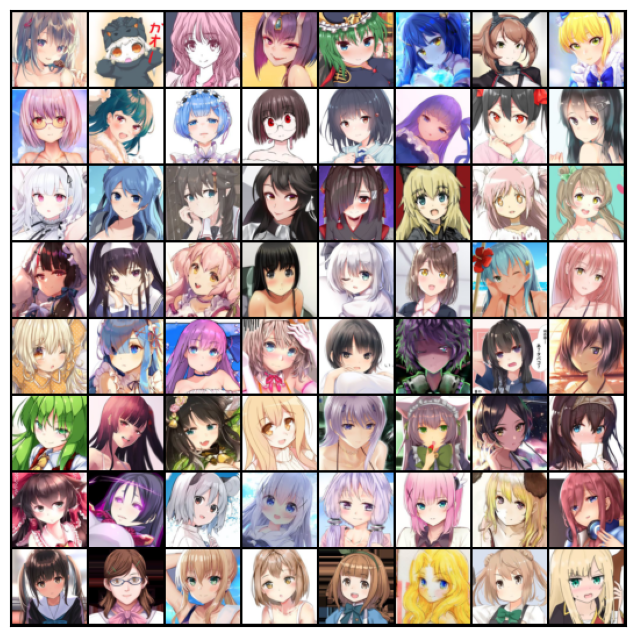

In [18]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [20]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [21]:
train_dl = DeviceDataLoader(train_dl, device)

In [22]:
import torch.nn as nn

In [23]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [24]:
discriminator = to_device(discriminator, device)

In [25]:
latent_size = 128

In [26]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [27]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([128, 3, 64, 64])


As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [28]:
generator = to_device(generator, device)

In [29]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [30]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [31]:
from torchvision.utils import save_image

In [32]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [33]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [34]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


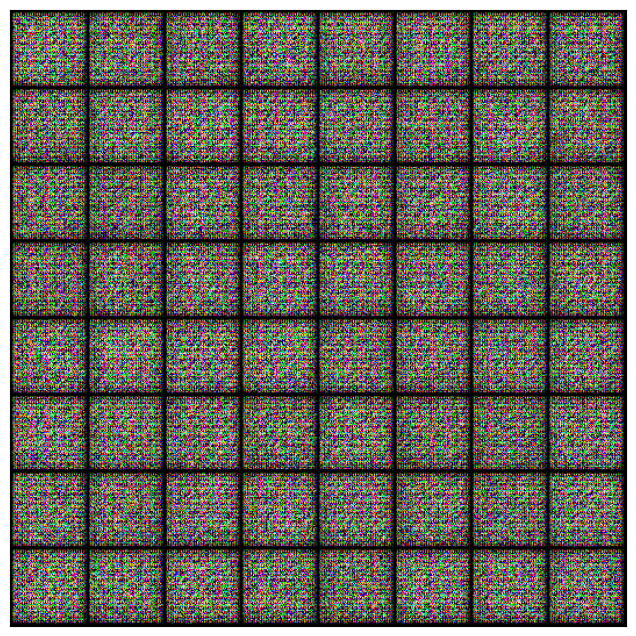

In [35]:
save_samples(0, fixed_latent)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [40]:
lr = 0.0002
epochs = 30

In [41]:
history = fit(epochs, lr)

  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 3.3326, loss_d: 0.3531, real_score: 0.8562, fake_score: 0.0114
Saving generated-images-0001.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 1.7144, loss_d: 0.2364, real_score: 0.8327, fake_score: 0.0288
Saving generated-images-0002.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 3.9517, loss_d: 1.8102, real_score: 0.3016, fake_score: 0.0001
Saving generated-images-0003.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 4.9875, loss_d: 0.1324, real_score: 0.9745, fake_score: 0.0944
Saving generated-images-0004.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 4.2794, loss_d: 0.0734, real_score: 0.9865, fake_score: 0.0546
Saving generated-images-0005.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 4.6818, loss_d: 0.0888, real_score: 0.9577, fake_score: 0.0420
Saving generated-images-0006.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 5.3017, loss_d: 0.0750, real_score: 0.9890, fake_score: 0.0576
Saving generated-images-0007.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 3.8195, loss_d: 0.1121, real_score: 0.9179, fake_score: 0.0203
Saving generated-images-0008.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 3.8608, loss_d: 0.1710, real_score: 0.8692, fake_score: 0.0074
Saving generated-images-0009.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 5.2488, loss_d: 0.0801, real_score: 0.9757, fake_score: 0.0511
Saving generated-images-0010.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 5.1851, loss_d: 0.1441, real_score: 0.9778, fake_score: 0.1039
Saving generated-images-0011.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 2.9439, loss_d: 0.1948, real_score: 0.8729, fake_score: 0.0287
Saving generated-images-0012.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 4.9486, loss_d: 0.0632, real_score: 0.9759, fake_score: 0.0361
Saving generated-images-0013.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 4.0504, loss_d: 0.1578, real_score: 0.9250, fake_score: 0.0625
Saving generated-images-0014.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 4.1938, loss_d: 0.0918, real_score: 0.9393, fake_score: 0.0236
Saving generated-images-0015.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 4.4614, loss_d: 0.0492, real_score: 0.9907, fake_score: 0.0367
Saving generated-images-0016.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 3.3955, loss_d: 6.1673, real_score: 0.0059, fake_score: 0.0000
Saving generated-images-0017.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 5.5611, loss_d: 0.1047, real_score: 0.9844, fake_score: 0.0795
Saving generated-images-0018.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 3.3216, loss_d: 0.1405, real_score: 0.9103, fake_score: 0.0322
Saving generated-images-0019.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 3.1422, loss_d: 1.5411, real_score: 0.3169, fake_score: 0.0006
Saving generated-images-0020.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 1.7428, loss_d: 0.3952, real_score: 0.7486, fake_score: 0.0529
Saving generated-images-0021.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 18.6784, loss_d: 1.5569, real_score: 0.9999, fake_score: 0.6851
Saving generated-images-0022.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 3.6025, loss_d: 0.2779, real_score: 0.9242, fake_score: 0.1413
Saving generated-images-0023.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 3.4885, loss_d: 0.4054, real_score: 0.8538, fake_score: 0.1613
Saving generated-images-0024.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 4.6116, loss_d: 0.1900, real_score: 0.9356, fake_score: 0.0872
Saving generated-images-0025.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 6.8176, loss_d: 0.0748, real_score: 0.9970, fake_score: 0.0617
Saving generated-images-0026.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 5.1098, loss_d: 0.0856, real_score: 0.9848, fake_score: 0.0622
Saving generated-images-0027.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 6.6333, loss_d: 0.3219, real_score: 0.9964, fake_score: 0.2269
Saving generated-images-0028.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 0.1846, loss_d: 4.8678, real_score: 0.0370, fake_score: 0.0001
Saving generated-images-0029.png


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 3.0509, loss_d: 0.1704, real_score: 0.9021, fake_score: 0.0470
Saving generated-images-0030.png


In [42]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [45]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [49]:
torch.save(generator, 'generator.pt')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [46]:
from IPython.display import Image

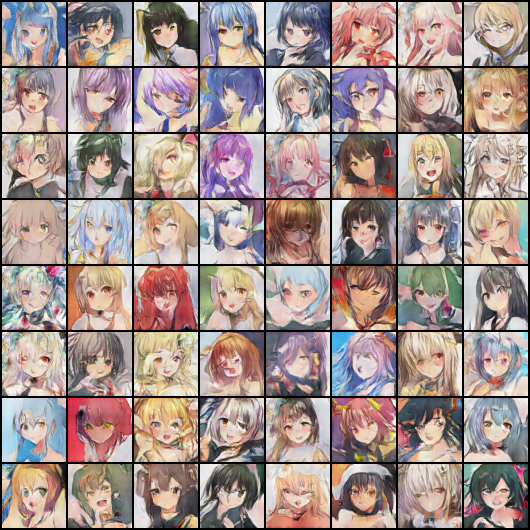

In [47]:
Image('./generated/generated-images-0030.png')

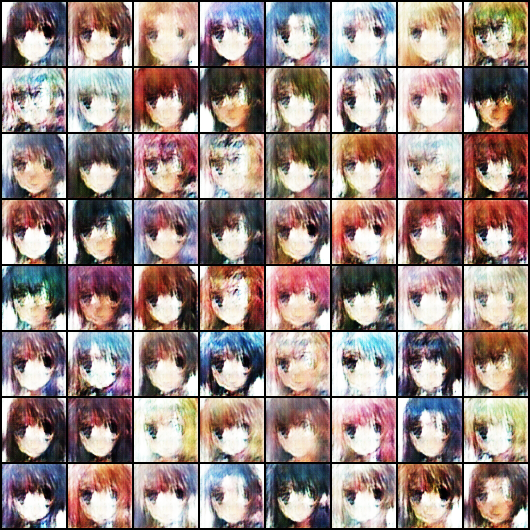

In [ ]:
Image('./generated/generated-images-0005.png')

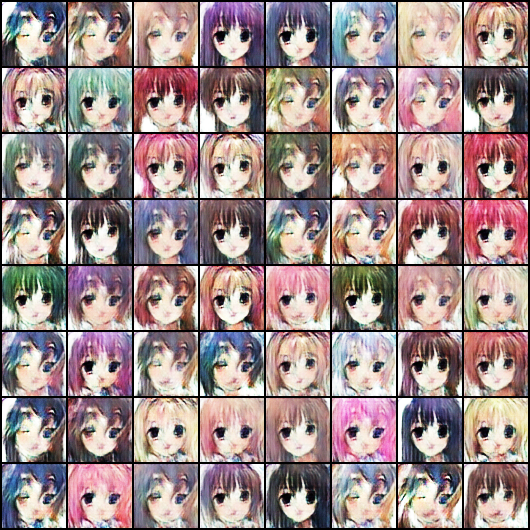

In [ ]:
Image('./generated/generated-images-0010.png')

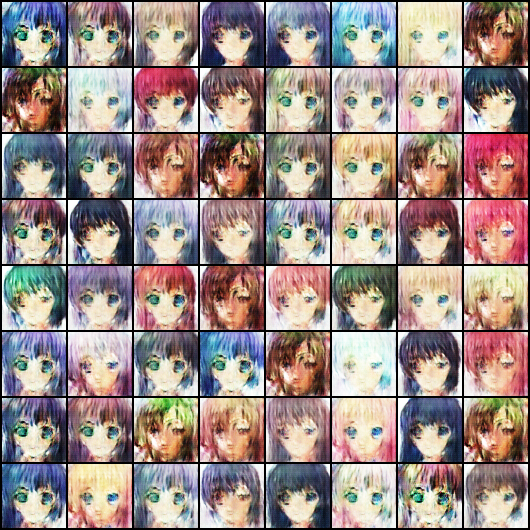

In [ ]:
Image('./generated/generated-images-0020.png')

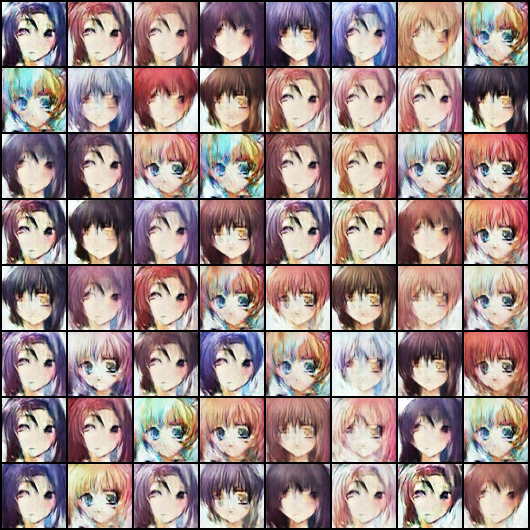

In [ ]:
Image('./generated/generated-images-0025.png')

In [50]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



In [55]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

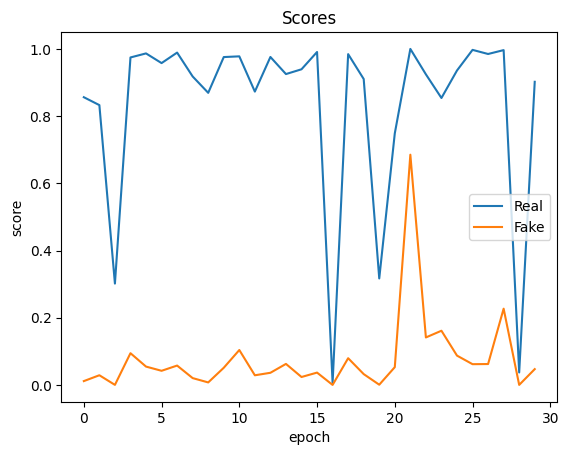

In [56]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [57]:
real_scores


[0.8561698794364929,
 0.8326672315597534,
 0.30155372619628906,
 0.9744677543640137,
 0.9865134954452515,
 0.9577067494392395,
 0.9889724850654602,
 0.9178730845451355,
 0.8691948056221008,
 0.9756500720977783,
 0.9777794480323792,
 0.8728769421577454,
 0.9759010672569275,
 0.9250449538230896,
 0.9392741322517395,
 0.990729570388794,
 0.00585219357162714,
 0.9843730330467224,
 0.9103423953056335,
 0.31685709953308105,
 0.7485930323600769,
 0.9998709559440613,
 0.9242419004440308,
 0.8538460731506348,
 0.9356481432914734,
 0.9970412850379944,
 0.9847813248634338,
 0.9963564872741699,
 0.03704025223851204,
 0.9020568132400513]